<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://storage.googleapis.com/dlops-content/public/univailogo.jpeg" height="50px"> <a href='https://welcome.univ.ai/AcceleratedMasters/ai5-c1/' target='_blank'><strong><font color="#324bd9">AI-5: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#324bd9">Lecture 4 - Mushroom Classification Models</font>**

**Univ.AI**<br/>
**August 2021**<br/>
**Authors/Instructors:**<br/>
Pavlos Protopapas, Shivas Jayaram

<hr style="height:2pt">

## **<font color="#324bd9">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Mon Aug 23 02:24:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    222MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(dataset_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **<font color="#324bd9">Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_3_labels.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.13500046730041504


### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [ ]:
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['amanita', 'oyster', 'crimini']
Full size of the dataset: 1643
data_list: [('amanita', 'datasets/mushrooms/amanita/511.jpg'), ('amanita', 'datasets/mushrooms/amanita/431.jpg'), ('amanita', 'datasets/mushrooms/amanita/41.jpg'), ('amanita', 'datasets/mushrooms/amanita/122.jpg'), ('amanita', 'datasets/mushrooms/amanita/33.jpg')]


### **View Images**

Let's take a look at the data.

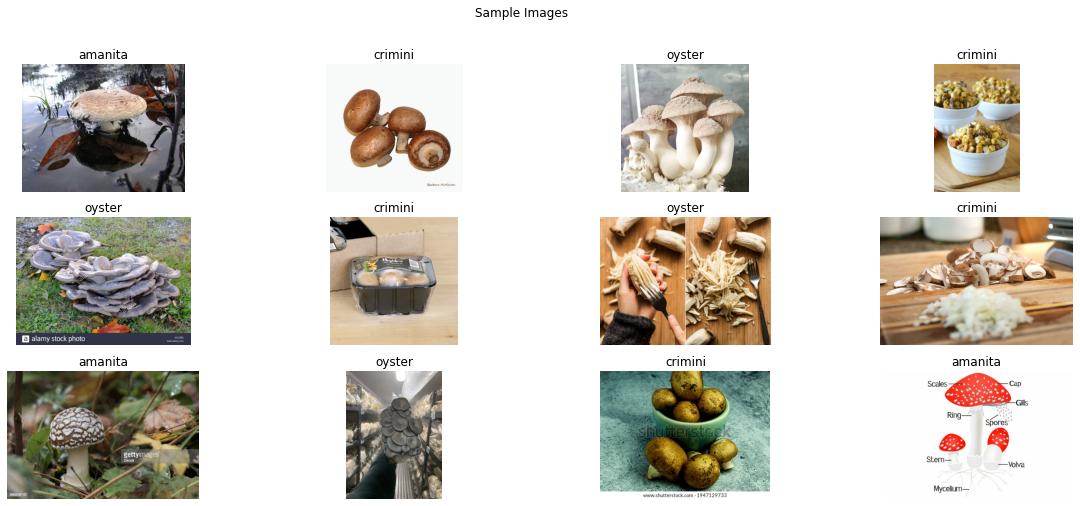

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### **Dataset Metrics**

In [ ]:
# Compute dataset metrics
compute_dataset_metrics(data_list)

Dataset Metrics:
----------------
Label Counts:
crimini    561
oyster     547
amanita    535
Name: label, dtype: int64
Image Width:
Min: 135.0  Max: 4288.0
Image Height:
Min: 120.0  Max: 4032.0
Size in memory: 4580.16 MB


## **<font color="#324bd9">Build Data Pipelines</font>**

### **Load X & Y** 

Generate data_x and data_y

In [ ]:
# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 1643
data_y: 1643
data_x: ['datasets/mushrooms/amanita/511.jpg', 'datasets/mushrooms/amanita/431.jpg', 'datasets/mushrooms/amanita/41.jpg', 'datasets/mushrooms/amanita/122.jpg', 'datasets/mushrooms/amanita/33.jpg']
data_y: ['amanita', 'amanita', 'amanita', 'amanita', 'amanita']


### **Split Data** 
We split data into test, validation, & train

In [ ]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 1330
validate_x count: 148
test_x count: 165


### **Create TF Datasets**

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32

train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
test_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>


## **<font color="#324bd9">Image Classificaton Models</font>**

### **Create Experiment**

We will use our util functions to create an experiment to keep track of hyper parameters, metrics, models etc.

In [ ]:
# Create an experiment
create_experiment()

In [ ]:
# Save data details used for the experiment
data_details = {
  "image_width": image_width,
  "image_height": image_height,
  "num_channels": num_channels,
  "num_classes": num_classes,
  "label2index": label2index,
  "index2label": index2label,
  "train_x":train_x,
  "train_y":train_y,
  "validate_x":validate_x,
  "validate_y":validate_y,
  "test_x":test_x,
  "test_y":test_y
}
save_data_details(data_details)

### **1) Two Block CNN Network**

In [ ]:
# Build Model
def build_2_block_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='2_block')

  return model

### **Train**

Model: "2_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0   

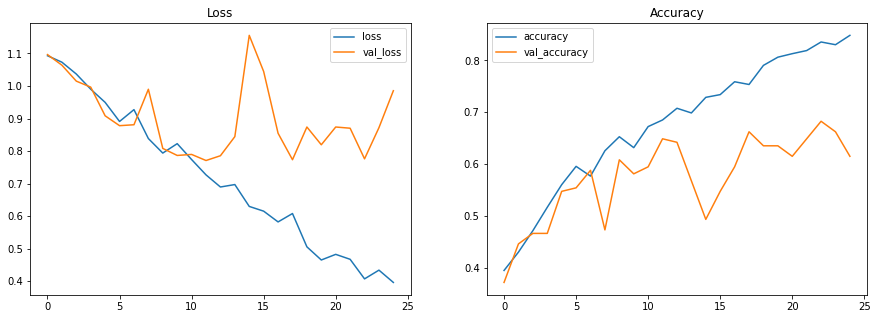

6/6 [==============================] - 2s 274ms/step - loss: 0.9100 - accuracy: 0.6606
[0.9100044965744019, 0.6606060862541199]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 25

# Free up memory
K.clear_session()

# Build the model
model = build_2_block_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
# Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        callbacks=[],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **2) Four Block CNN Network**

In [ ]:
# Build Model
def build_4_block_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='4_block')

  return model

### **Train**

Model: "4_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0   

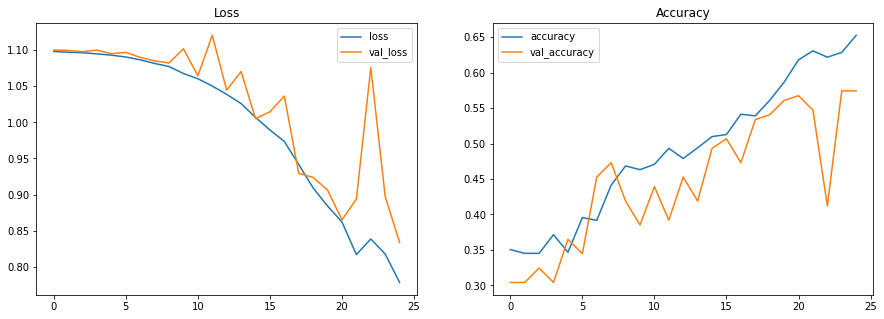

6/6 [==============================] - 2s 260ms/step - loss: 0.7945 - accuracy: 0.6121
[0.7945115566253662, 0.6121212244033813]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 25

# Free up memory
K.clear_session()

# Build the model
model = build_4_block_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
# Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        callbacks=[],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **3) VGG Style Network**

In [ ]:
# Build Model
def build_vgg_style_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='vgg_style')

  return model

### **Train**

Model: "vgg_style"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0 

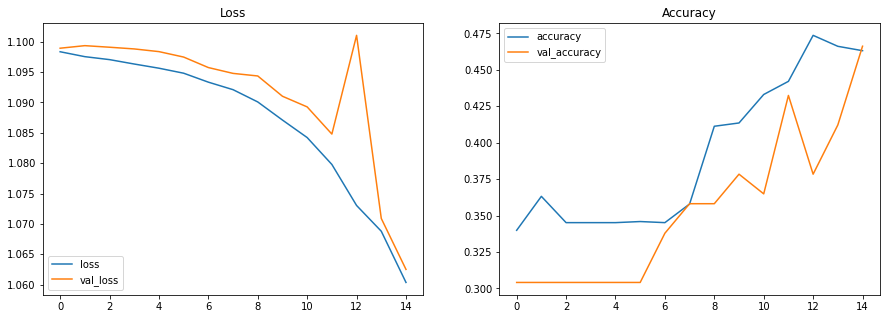

6/6 [==============================] - 1s 138ms/step - loss: 1.0346 - accuracy: 0.4606
[1.034582495689392, 0.46060606837272644]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 15

# Free up memory
K.clear_session()

# Build the model
model = build_vgg_style_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **4) MobileNet - Transfer Learning**

In [ ]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        tranfer_model_base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(units=128, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='mobilenetv2_train_base_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_train_base_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/15
42/42 [==============================] - 15s 299ms/step - loss: 107.4660 - accuracy: 0.4647 - val_loss: 105.9242 - val_accuracy: 0.5946
Epoch

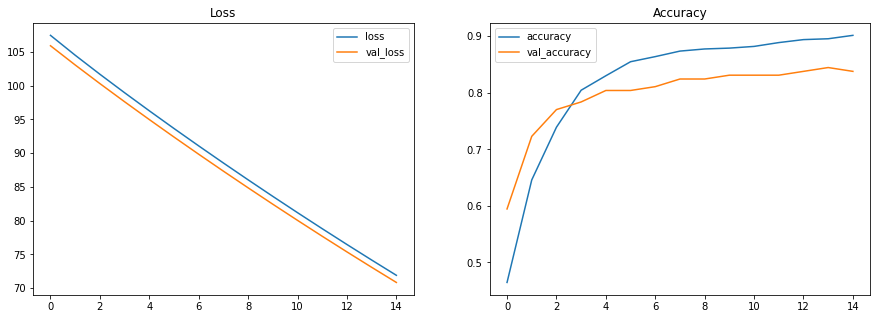

6/6 [==============================] - 1s 192ms/step - loss: 70.7615 - accuracy: 0.8970
[70.76146697998047, 0.8969696760177612]


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 15

# Free up memory
K.clear_session()

# Build the model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Train - Fine-Tuning**

Unfreeze the base

Model: "mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 2,388,227
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 18s 332ms/step - loss: 107.6297 - accuracy: 0.5143 - val_loss: 106.0580 - val_accuracy: 0.5946
Epoch 2/10
42/42 [==============================] - 14s 316ms/step - l

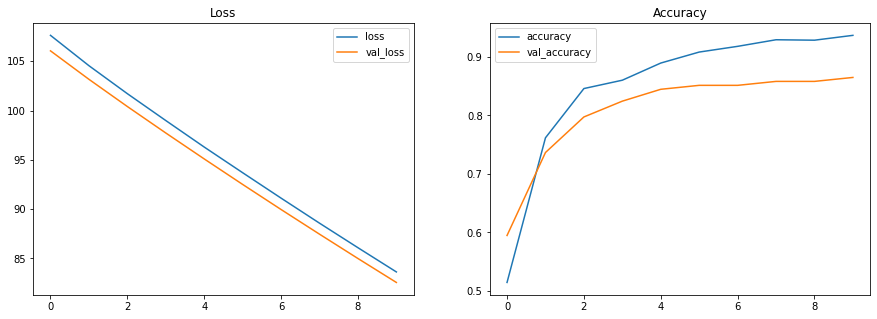

6/6 [==============================] - 1s 129ms/step - loss: 82.4843 - accuracy: 0.8727
[82.4842758178711, 0.8727272748947144]


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = True)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **MobileNet - Transfer Learning (From TFHub)**

[TensorFlow Hub](https://tfhub.dev/) is a repository where hundreds of machine learning models come together in one place

In [ ]:
# Build Model
def build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(handle, trainable=train_base),
        keras.layers.Dense(units=64, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='tfhub_mobilenetv2_train_base_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

Model: "tfhub_mobilenetv2_train_base_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 15s 283ms/step - loss: 55.7380 - accuracy: 0.4173 - val_loss: 54.9486 - val_accuracy: 0.4392
Epoch 2/10
42/42 [==============================] - 11s 272ms/step - loss: 54.1801 - accuracy: 0.5436 - val_loss: 53.4542 - val_accuracy: 0.5811
Epoch 3/10
42/42 [==============================] - 

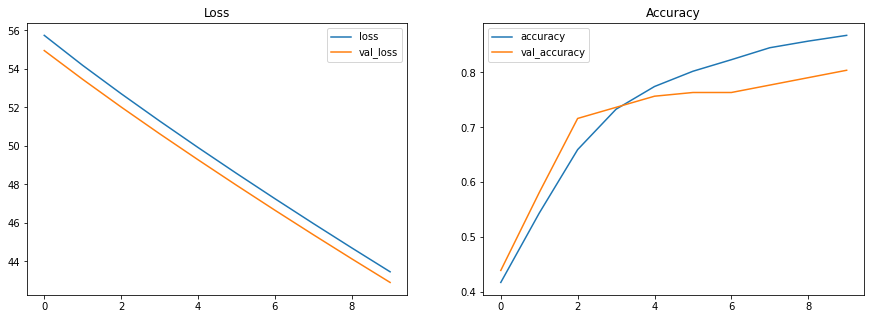

6/6 [==============================] - 1s 124ms/step - loss: 42.8369 - accuracy: 0.8667
[42.836891174316406, 0.8666666746139526]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = False)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Train - Fine-Tuning**

Unfreeze the base

Model: "tfhub_mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 2,306,051
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 19s 331ms/step - loss: 55.7183 - accuracy: 0.5744 - val_loss: 54.8610 - val_accuracy: 0.6486
Epoch 2/10
42/42 [==============================] - 14s 319ms/step - loss: 54.0789 - accuracy: 0.7744 - val_loss: 53.3788 - val_accuracy: 0.7770
Epoch 3/10
42/42 [==============================] - 1

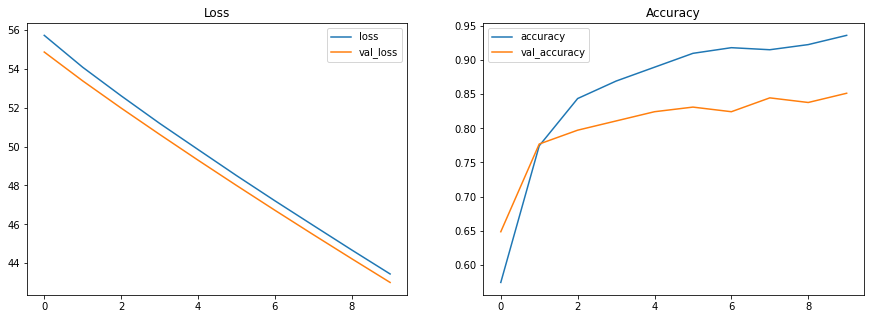

6/6 [==============================] - 1s 124ms/step - loss: 42.8956 - accuracy: 0.8788
[42.89556121826172, 0.8787878751754761]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = True)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

## **<font color="#324bd9">Experiment Results</font>**

#### **Compare Models**

In [ ]:
models_metrics_list = glob(experiment_name+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(experiment_name+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"164,355",4.26 mins,70.76,89.70%,10 MB,0.001,32,15,SGD,mobilenetv2_train_base_False
5,"2,306,051",2.71 mins,42.90,87.88%,10 MB,0.001,32,10,SGD,tfhub_mobilenetv2_train_base_True
2,"2,388,227",2.78 mins,82.48,87.27%,10 MB,0.001,32,10,SGD,mobilenetv2_train_base_True
4,"82,179",2.56 mins,42.84,86.67%,10 MB,0.001,32,10,SGD,tfhub_mobilenetv2_train_base_False
6,"25,950,531",7.44 mins,0.91,66.06%,104 MB,0.010,32,25,SGD,2_block
3,"11,112,323",7.58 mins,0.79,61.21%,45 MB,0.010,32,25,SGD,4_block
1,"22,514,755",4.70 mins,1.03,46.06%,90 MB,0.010,32,15,SGD,vgg_style


#### **Find Best Model**

In [ ]:
best_model = experiment_name+'/'+view_metrics.iloc[0]["name"]+".hdf5"
print(best_model)

experiment_1629685529/mobilenetv2_train_base_False.hdf5


### **Predict using the best model**

In [ ]:
# Load a model from disk
prediction_model = tf.keras.models.load_model(best_model, custom_objects={'KerasLayer':hub.KerasLayer})
#prediction_model = tf.keras.models.load_model(best_model)
prediction_model.summary()

Model: "mobilenetv2_train_base_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_________________________________________________________________


predictions.shape: (12, 3)
[0.1971383  0.33618152 0.46668017] 2


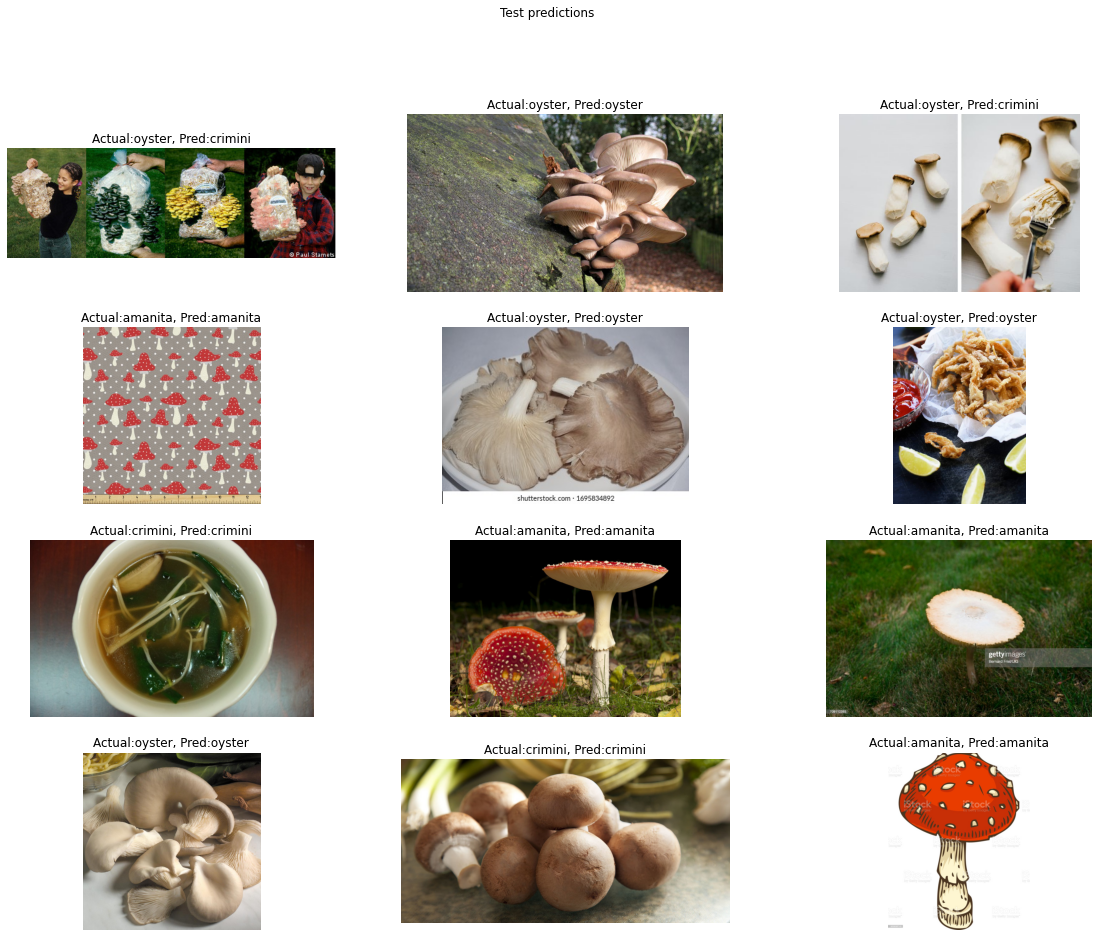

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(20,15))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)
    
    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = index2label[predictions[i].argmax()]
    axs.set_title("Actual:"+test_y[img_idx]+", Pred:"+prediction_label)


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()

## **<font color="#324bd9">Upload Experiment to Cloud Storage</font>**

### **Check Access to Bucket**

In [ ]:
# Authenticate
auth.authenticate_user()

In [ ]:
# Check the logged in account
user_account = !gcloud config get-value account
user_account = user_account[0]
print("user_account",user_account)

user_account shivasj@gmail.com


In [ ]:
# Check Bucket Access
bucket_name = "ai5-mushroom-app-models" # BUCKET NAME

# List buckets in a GCP project
storage_client = storage.Client(project="ai5-project") # YOUR PROJECT ID 

# Get bucket for Experiments
bucket = storage_client.get_bucket(bucket_name)
print("Model Bucket:",bucket)

# Test Write access
test_file = "test-access-"+user_account+".txt"
with open(test_file, "w") as f:
  f.write(user_account+" has access!")

blob = bucket.blob(test_file) 
print('Uploading file', test_file)
blob.upload_from_filename(test_file)

# List contents of s bucket
blobs = bucket.list_blobs(prefix="", delimiter="/")
for blob in blobs:
  print(blob)

Model Bucket: <Bucket: ai5-mushroom-app-models>
Uploading file test-access-shivasj@gmail.com.txt
<Blob: ai5-mushroom-app-models, test-access-shivasj@gmail.com.txt, 1629687527784217>


### **Save Experiment**

In [ ]:
# Copy the experiment folder to GCP Bucket
for file_path in glob(experiment_name+'/*'):
  print(file_path)
  blob = bucket.blob(os.path.join(user_account,file_path)) 
  print('uploading file', file_path)
  blob.upload_from_filename(file_path)

experiment_1629685529/4_block.h5
uploading file experiment_1629685529/4_block.h5
experiment_1629685529/4_block.json
uploading file experiment_1629685529/4_block.json
experiment_1629685529/tfhub_mobilenetv2_train_base_False.h5
uploading file experiment_1629685529/tfhub_mobilenetv2_train_base_False.h5
experiment_1629685529/mobilenetv2_train_base_True.json
uploading file experiment_1629685529/mobilenetv2_train_base_True.json
experiment_1629685529/vgg_style.h5
uploading file experiment_1629685529/vgg_style.h5
experiment_1629685529/tfhub_mobilenetv2_train_base_True.h5
uploading file experiment_1629685529/tfhub_mobilenetv2_train_base_True.h5
experiment_1629685529/2_block_train_history.json
uploading file experiment_1629685529/2_block_train_history.json
experiment_1629685529/mobilenetv2_train_base_False_model_metrics.json
uploading file experiment_1629685529/mobilenetv2_train_base_False_model_metrics.json
experiment_1629685529/tfhub_mobilenetv2_train_base_False.hdf5
uploading file experiment_

## **<font color="#324bd9">Exercise / Competition</font>**

### **<font color="#f03b20">Due Date: August 29th before class</font>**

Now your task for this exercise is to build the best model for mushroom classification. You are free to use any techniques. Here are some techniques you can try:

* Data augmentation
* Hyper parameters tuning
* Transfer Learning using different pre-trained models
* Learning rate schedulers
* Early stopping
* etc...

<br>

**Remember to submit your experiments to the cloud storage bucket**

<br>

**<font color="#f03b20">Leaderboard for this competition will be computed based on both model size and accuracy of model. Winner gets a $50 Amazon gift card from Pavlos</font>**